<h1>Thunderstorms in Texas with income and storm order</h1>

<p>In this notebook, we add both mean income per county and "storm order" as input features to the data. The idea is that we would like to found out how much (if any) these features can improve our data.</p>

In [2]:
# packages used
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (8.25, 6)
import seaborn as sns

In [3]:
# load top 500 thunderstorms in texas from 1950 - 2018
data = pd.read_csv("texas_thunderstorm.csv", usecols=[1, 2, 3, 4, 6, 7, 10, 11, 29, 30, 31, 32, 33])
data.info()

# Randomize the data
data = data.sample(frac=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 13 columns):
CZ_NAME_STR            352 non-null object
BEGIN_LOCATION         352 non-null object
BEGIN_DATE             352 non-null object
BEGIN_TIME             352 non-null int64
MAGNITUDE              352 non-null float64
STORM_ORDER            352 non-null int64
DAMAGE_PROPERTY_NUM    352 non-null int64
DAMAGE_CROPS_NUM       352 non-null int64
END_LOCATION           352 non-null object
BEGIN_LAT              352 non-null float64
BEGIN_LON              352 non-null float64
END_LAT                352 non-null float64
END_LON                352 non-null float64
dtypes: float64(5), int64(4), object(4)
memory usage: 35.8+ KB


In [4]:
# The outcomes = what we're trying to predict
thunderstorm_outcomes = data.iloc[:, [6]]

list(thunderstorm_outcomes)
thunderstorm_outcomes

DAMAGE_PROPERTY_NUM
301              3000000
291               250000
18               5000000
326              1000000
139              5000000
310               800000
63               1500000
158               350000
166               250000
208              1000000
106              5000000
332               500000
334              1500000
0                 400000
84                200000
172              4000000
286               200000
252               189000
56               2000000
257               500000
115               500000
110               350000
77                250000
295               500000
174               200000
225               450000
35                500000
230               500000
88                300000
234               200000
..                   ...
278             15000000
339               750000
182               300000
242               700000
198               500000
19                200000
206               350000
260               200000
338               500000
25                500000
101               500000
144               250000
75                500000
224               250000
218               500000
183               300000
14                500000
303               200000
72                500000
137               200000
185               500000
104               375000
36                200000
204              5000000
299               200000
216               500000
6                 250000
282               250000
97               1100000
330              1000000

[352 rows x 1 columns]

In [5]:
# The predictors = the features we are using to predict property damage in Texas
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE'], axis=1)

list(thunderstorm_predictors)

['BEGIN_TIME',
 'MAGNITUDE',
 'STORM_ORDER',
 'DAMAGE_CROPS_NUM',
 'BEGIN_LAT',
 'BEGIN_LON',
 'END_LAT',
 'END_LON']

In [6]:
# load mean income data per county
texas_income_data = pd.read_csv("MACHINE_LEARNING_DATA/county_year/texas_median_county_income_all.csv")
texas_income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3302 entries, 0 to 3301
Data columns (total 2 columns):
name        3302 non-null object
estimate    3301 non-null float64
dtypes: float64(1), object(1)
memory usage: 51.7+ KB


In [8]:
# Add column to input features
# 1990, 2000, 2009 forward, using the closest year available if the exact year does not exist
def parse_date(year):
    if int(year) < 95:
        return '1990'
    elif int(year) >= 95 or int(year) < 5:
        return '2000'
    elif int(year) >= 5 and int(year) < 9:
        return '2009'
    elif int(year) >= 9:
        return '20' + year
    
# add a mean income column to the input features
def add_mean_income(thunderstorm_predictors):
    thunderstorm_predictors['MEAN_INCOME'] = 100
    years = [date.split('/')[-1] for date in data['BEGIN_DATE']]
    years = [parse_date(year) for year in years]
    estimates = []
    for i in range(len(thunderstorm_predictors)):
        keyword = data['CZ_NAME_STR'][i] + years[i]
        estimate = texas_income_data[texas_income_data['name'] == keyword].values[0][1]
        estimates.append(estimate)
    thunderstorm_predictors['MEAN_INCOME'] = estimates

In [9]:
add_mean_income(thunderstorm_predictors)

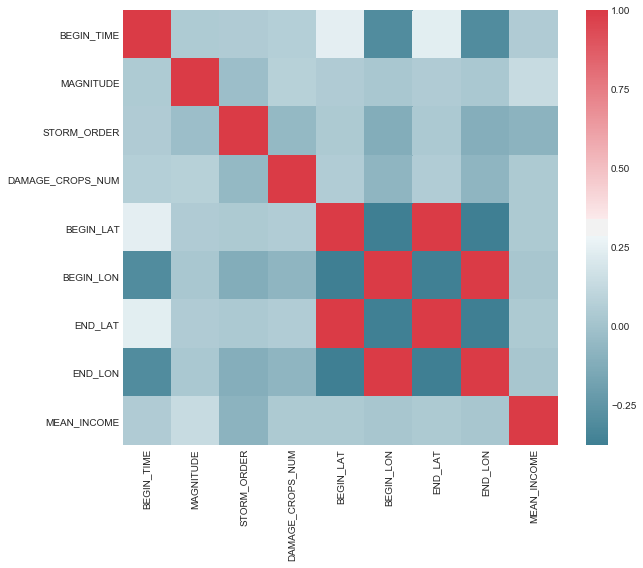

In [10]:
corr = thunderstorm_predictors.corr()

# plot correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [11]:
def preprocess(thunderstorm_outcomes, thunderstorm_predictors):
    '''
        This function takes in both the input features and the outcome data for the property damage.
        The input features are all normalized by subtracting the mean and dividing by the standard 
        deviation. The outcome data is normalized by first transforming it to a log scale and then doing
        mean normalization. 
    '''
    # Make the outcomes into a numpy array
    outcome_array = thunderstorm_outcomes.values.astype(np.float)
    
    # log scale
    outcome_array = np.log(outcome_array + 1)

    # split into test and training data
    split_index = int(0.8 * len(outcome_array))
    outcome_array_train = outcome_array[:split_index, :]
    outcome_array_test = outcome_array[split_index:, :]
    print(outcome_array_train.shape)
    print('Shape of outcome array training', outcome_array_train.shape)
    print('Shape of outcome array test', outcome_array_test.shape)
    
    # normalize outcome
    outcome_array_train = (outcome_array_train - np.mean(outcome_array))/np.std(outcome_array)
    outcome_array_test = (outcome_array_test - np.mean(outcome_array))/np.std(outcome_array)
    
    outcome_mean_log = np.mean(outcome_array)
    outcome_std_log = np.std(outcome_array)

    # Make that numpy array into a torch Tensor
    outcome_Tensor_train = torch.from_numpy(outcome_array_train)
    outcome_Tensor_test = torch.from_numpy(outcome_array_test)

    # Make the predictors into a numpy array
    predictors_array = thunderstorm_predictors.values
    # NOTE: we took out any missing data values in the csv 

    # split into test and training data
    predictors_array_train = predictors_array[:split_index, :]
    predictors_array_test = predictors_array[split_index:, :]
    print('Shape of inputs array training', predictors_array_train.shape)
    print('Shape of inputs array test', predictors_array_test.shape)

    # Normalize inputs
    predictors_array_train = (predictors_array_train - np.mean(predictors_array, axis=0))/np.std(predictors_array, axis=0)
    predictors_array_test = (predictors_array_test - np.mean(predictors_array, axis=0))/np.std(predictors_array, axis=0)

    # Make that numpy array into a torch Tensor
    predictors_Tensor_train = torch.from_numpy(predictors_array_train.astype(np.float))
    predictors_Tensor_test = torch.from_numpy(predictors_array_test.astype(np.float))

    # Convert those DoubleTensors to FloatTensors
    # Chaning outcomes from a DoubleTensor to a FloatTensor
    outcome_Tensor_train = outcome_Tensor_train.float()
    outcome_Tensor_test = outcome_Tensor_test.float()

    # Changing the predictors too
    predictors_Tensor_train = predictors_Tensor_train.float()
    predictors_Tensor_test = predictors_Tensor_test.float()
    
    return (predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,
            outcome_Tensor_test, outcome_mean_log, outcome_std_log)

(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean_log, outcome_std_log) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)


<h1>One hidden layer</h1>

In [12]:
class one_hidden_Net(torch.nn.Module):
    def __init__(self):
        super(one_hidden_Net, self).__init__()
        self.fc1 = torch.nn.Linear(9, 6)
        self.fc2 = torch.nn.Linear(6, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)
    
# Make it
one_hidden_model = one_hidden_Net()

In [13]:
# Define the loss function
loss_fn = torch.nn.MSELoss(size_average = False)

/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [14]:
def train_neural_net(model, train_outcomes, train_inputs, test_outcomes, test_inputs):
    # Make an empty list to add to for each iteration
    current_loss_value_mini = []
    
    # For the cv too
    current_test_loss_value = []
    
    # Set the optimizer
    # originally step size was 1e-2
    optimizer = torch.optim.Adagrad(model.parameters(), lr = 1e-2)
    
    # Train the neural network
    # 100000 iterations seems to give much better results when networks is two layers deep
    for t in range(20000):
        # Get the current mini-batch indices
        indices = torch.randperm(len(train_inputs))[0:50]
        
        # Get the current mini-batches
        predictors_mini = train_inputs[indices]
        outcome_mini = train_outcomes[indices]
        
        # Get the current predictions
        current_pred_mini = model(predictors_mini)
        test_pred = model(test_inputs)
        
        # Compute current losses and and append that to the empty list
        current_loss_mini = loss_fn(current_pred_mini, outcome_mini)
        current_loss_value_mini.append(current_loss_mini.data.item())
        
        current_test_loss = loss_fn(test_pred, test_outcomes)
        current_test_loss_value.append(current_test_loss.data.item())
        
        # Zero the gradients before backwards pass
        optimizer.zero_grad()
        
        # Backwards pass
        current_loss_mini.backward()
        
        # Update model parameters
        optimizer.step()
        
    # Get iterations as a list for x-axis of plot
    iterations = list(range(0, 20000))
    
    # Convert total square error to mean square error
    mse = (np.asarray(current_loss_value_mini) / len(predictors_mini)).tolist()
    
    # For cv too
    mse_test = (np.asarray(current_test_loss_value) / len(test_inputs)).tolist()
    
    # Plot loss versus iteration
    plt.plot(iterations, mse)
    plt.plot(iterations, mse_test, "r-")
    plt.xlabel("Iteration", size = 14)
    plt.ylabel("Loss Value", size = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title("How'd the Optimizing Go?", size = 16)

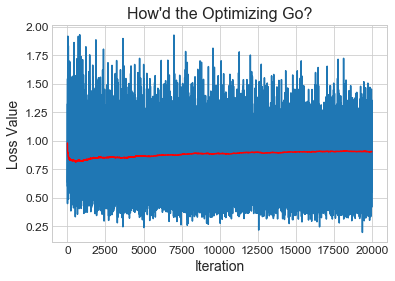

In [15]:
train_neural_net(one_hidden_model, outcome_Tensor_train, predictors_Tensor_train, 
                 outcome_Tensor_test, predictors_Tensor_test)

In [16]:
def plot_train_perf(train_predictors, train_obs, model):
    
    # Plots how well the model performs on training data
    # train_predictors = the values that the model predicts from, PyTorch Tensor
    # train_obs = what the model would ideally predict, PyTorch Tensor
    # Returns a plot
    
    
    # Get the predictions
    train_predictors.requires_grad = False
    train_predictions = model(train_predictors)
    
    # Convert that to a numpy array
    train_predictions = train_predictions.data.numpy()
    
    # Put it in log-transformed scale and convert it to a list
    train_predictions = (train_predictions*outcome_std_log + outcome_mean_log).tolist()
    
    
    # Put the observed outcomes in log-transformed scale
    # and convert it to a list
    train_obs = (train_obs.numpy()*outcome_std_log + outcome_mean_log).tolist()
    
    
    # Plot it
    plt.scatter(train_obs, train_predictions, facecolors = "none", edgecolors = "k")
    axes = plt.gca()
    axes.set_xlim([-1, 24])
    axes.set_ylim([-1, 24])
    axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)
    axes.set_xlabel("Observed (Log-Transformed US Dollars)", size = 14)
    axes.set_ylabel("Predicted (Log-Transformed US Dollars)", size = 14)
    axes.set_title("Model Performance on Training Data", size = 16)

In [32]:
plot_train_perf(predictors_Tensor_train, outcome_Tensor_train, one_hidden_model)

RuntimeError: size mismatch, m1: [281 x 8], m2: [9 x 6] at /Users/soumith/mc3build/conda-bld/pytorch_1549597882250/work/aten/src/TH/generic/THTensorMath.cpp:940

In [33]:
def compute_MSE(predictors, observed_outcomes, model):
    
    # Computes the mean squared error of the model
    # predictors = the variables and values used in prediction
    # observed_outcomes = what the prediction would ideally yield
    # Returns a PyTorch Variable
    
    
    # Get the validation set predictions
    predictors.requires_grad = False
    predictions = model(predictors)
    
    # Get the validation set outcomes
    outcomes = observed_outcomes
    
    # Get the loss - (total) residual sum of squares
    total_SE = loss_fn(predictions, outcomes)
    
    # Average that to get mean square error
    mean_SE = total_SE / len(predictors)
    return(mean_SE)

In [34]:
one_hidden_MSE = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, one_hidden_model)
print("Mean squared error:", one_hidden_MSE.item())

RuntimeError: size mismatch, m1: [71 x 8], m2: [9 x 6] at /Users/soumith/mc3build/conda-bld/pytorch_1549597882250/work/aten/src/TH/generic/THTensorMath.cpp:940

In [35]:
def display_readable_predictions(predictors, observed_outcomes, model):
    '''
        This function gives us a better idea of how accurate our predictions are on the "real" (non-log)
        scale.
    '''
    predictions = np.exp((model(predictors) * outcome_std_log + outcome_mean_log).detach().numpy()) - 1
    
    observed = np.exp(observed_outcomes * outcome_std_log + outcome_mean_log) - 1
    
    for i in range(len(predictions)):
        print((predictions[i][0].item(), observed[i][0].item()))
        print(predictions[i][0].item() - observed[i][0].item())
    

In [23]:
# Display (predicted, observed)
#          difference
display_readable_predictions(predictors_Tensor_test, outcome_Tensor_test, one_hidden_model)

(601773.0, 199999.984375)
401773.015625
(6632110.0, 210000.0)
6422110.0
(1801991.75, 20000004.0)
-18198012.25
(417850.1875, 250000.0)
167850.1875
(507413.75, 500000.28125)
7413.46875
(554017.125, 250000.0)
304017.125
(410441.6875, 220000.09375)
190441.59375
(892159.8125, 1500000.75)
-607840.9375
(521007.5625, 2000000.375)
-1478992.8125
(587730.3125, 199999.984375)
387730.328125
(557998.75, 325000.03125)
232998.71875
(648389.1875, 300000.1875)
348389.0
(308564.21875, 199999.984375)
108564.234375
(416224.71875, 250000.0)
166224.71875
(425251.65625, 5000005.0)
-4574753.34375
(1193779.5, 300000.1875)
893779.3125
(448805.90625, 250000.0)
198805.90625
(994282.125, 1500000.75)
-505718.625
(1017276.625, 5000005.0)
-3982728.375
(363149.375, 500000.28125)
-136850.90625
(646720.5625, 250000.0)
396720.5625
(375092.78125, 2000000.375)
-1624907.59375
(556517.625, 250000.0)
306517.625
(403699.75, 1500000.75)
-1096301.0
(354990.8125, 275000.09375)
79990.71875
(673456.625, 500000.28125)
173456.34375
(6

<h2>Two hidden layers</h2>

In [24]:
class two_hidden_Net(torch.nn.Module):
    def __init__(self):
        super(two_hidden_Net, self).__init__()
        self.fc1 = torch.nn.Linear(9, 6)
        self.fc2 = torch.nn.Linear(6, 4)
        self.fc3 = torch.nn.Linear(4, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return(x)
    
# Make it
two_hidden_model = two_hidden_Net()

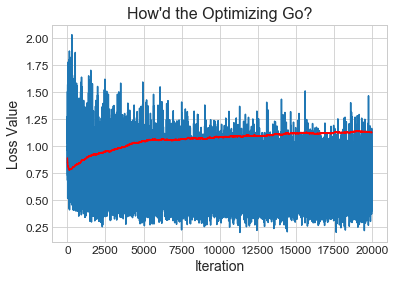

In [25]:
train_neural_net(two_hidden_model, outcome_Tensor_train, predictors_Tensor_train,
                outcome_Tensor_test, predictors_Tensor_test)

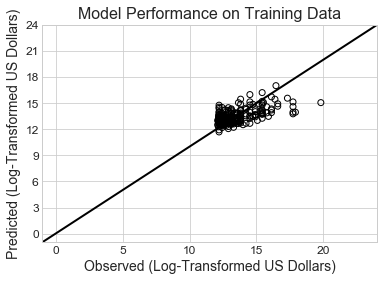

In [26]:
plot_train_perf(predictors_Tensor_train, outcome_Tensor_train, two_hidden_model)

In [28]:
MSE = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, two_hidden_model)
print('Mean squared error:', MSE.item())

Mean squared error: 1.1282517910003662


In [29]:
# Display (predicted, observed)
#          difference
display_readable_predictions(predictors_Tensor_test, outcome_Tensor_test, two_hidden_model)

(787235.8125, 199999.984375)
587235.828125
(6293555.5, 210000.0)
6083555.5
(2608166.75, 20000004.0)
-17391837.25
(368119.25, 250000.0)
118119.25
(811468.1875, 500000.28125)
311467.90625
(479378.96875, 250000.0)
229378.96875
(361511.46875, 220000.09375)
141511.375
(206634.828125, 1500000.75)
-1293365.921875
(308633.09375, 2000000.375)
-1691367.28125
(886245.0, 199999.984375)
686245.015625
(759072.625, 325000.03125)
434072.59375
(121529.2109375, 300000.1875)
-178470.9765625
(1157332.125, 199999.984375)
957332.140625
(437628.15625, 250000.0)
187628.15625
(760342.6875, 5000005.0)
-4239662.3125
(785555.125, 300000.1875)
485554.9375
(731286.9375, 250000.0)
481286.9375
(1920555.125, 1500000.75)
420554.375
(637288.75, 5000005.0)
-4362716.25
(432214.1875, 500000.28125)
-67786.09375
(1175795.25, 250000.0)
925795.25
(668171.75, 2000000.375)
-1331828.625
(407431.75, 250000.0)
157431.75
(301774.96875, 1500000.75)
-1198225.78125
(1504761.875, 275000.09375)
1229761.78125
(441798.9375, 500000.28125)
-

<h2>Feature importance evaluation</h2>
<p>In order to analyze feature importance evaluations, we defined a new neural net with one less input feature. For every feature, we train the one hidden layer network and observe the change in mean squared error.</p>

In [30]:
class leave_out_Net(torch.nn.Module):
    def __init__(self):
        super(leave_out_Net, self).__init__()
        self.fc1 = torch.nn.Linear(8, 5)
        self.fc2 = torch.nn.Linear(5, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)

<h3>Leave out BEGIN_TIME</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


NameError: name 'one_hidden_mse' is not defined

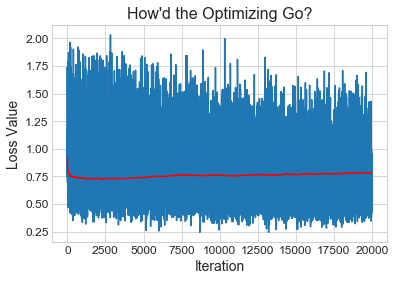

In [31]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'BEGIN_TIME'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_time_model = leave_out_Net()

# Train one layer
train_neural_net(without_time_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_time_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out DAMAGE_CROPS_NUM</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


0.9643511772155762

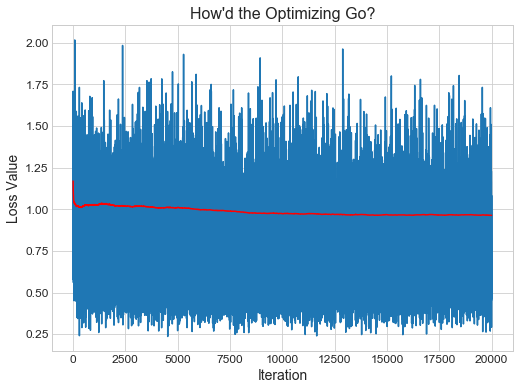

In [600]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'DAMAGE_CROPS_NUM'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_damage_crops_model = leave_out_Net()

# Train one layer
train_neural_net(without_damage_crops_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_damage_crops_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out STORM_ORDER</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


1.062511920928955

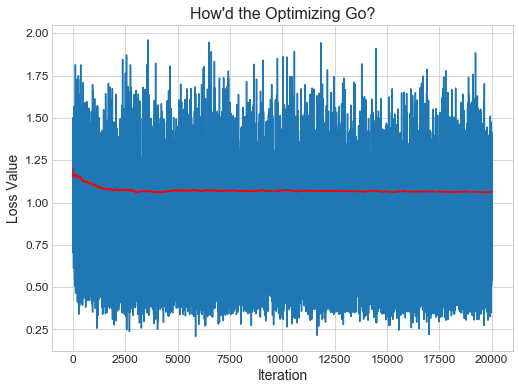

In [601]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'STORM_ORDER'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_storm_order_model = leave_out_Net()

# Train one layer
train_neural_net(without_storm_order_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_storm_order_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out MAGNITUDE</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


1.1245125532150269

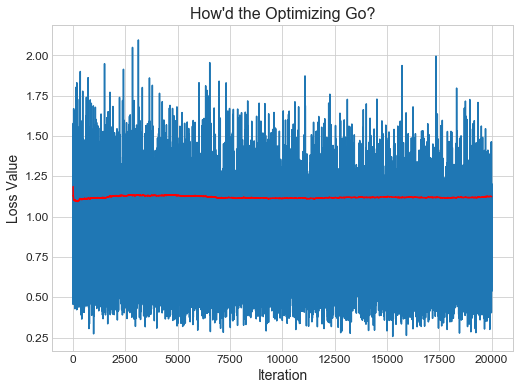

In [602]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'MAGNITUDE'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_magnitude_model = leave_out_Net()

# Train one layer
train_neural_net(without_magnitude_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_magnitude_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out BEGIN_LAT</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


1.0464245080947876

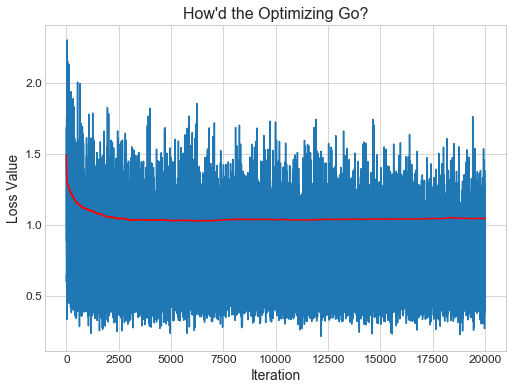

In [603]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'BEGIN_LAT'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_begin_lat_model = leave_out_Net()

# Train one layer
train_neural_net(without_begin_lat_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_begin_lat_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out BEGIN_LON</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


1.1291857957839966

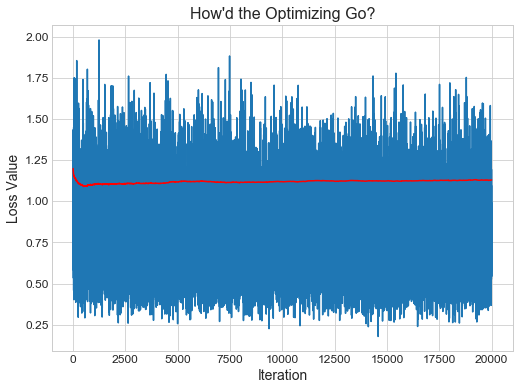

In [604]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'BEGIN_LON'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_begin_lon_model = leave_out_Net()

# Train one layer
train_neural_net(without_begin_lon_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_begin_lon_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out END_LAT</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


1.0543808937072754

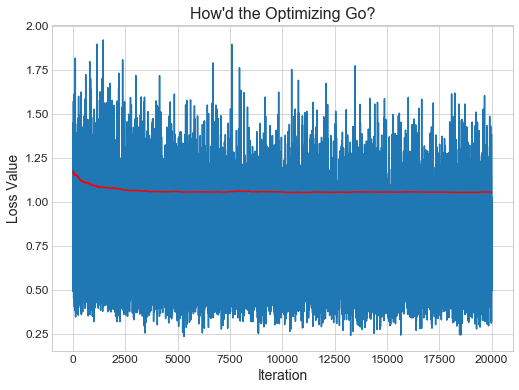

In [605]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'END_LAT'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_end_lat_model = leave_out_Net()

# Train one layer
train_neural_net(without_end_lat_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_end_lat_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out END_LON</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


1.0689170360565186

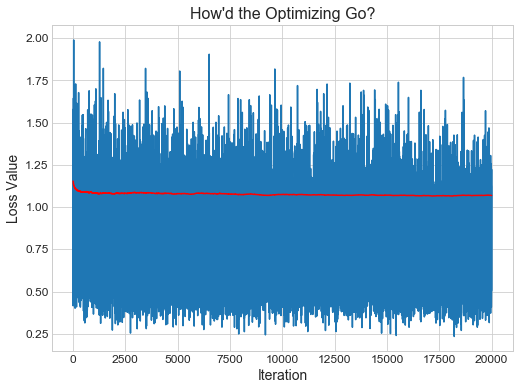

In [606]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE',
                                     'END_LON'], axis=1)
add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_end_lon_model = leave_out_Net()

# Train one layer
train_neural_net(without_end_lon_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_end_lon_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

<h3>Leave out MEAN_INCOME</h3>

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 8)
Shape of inputs array test (71, 8)


0.9976235032081604

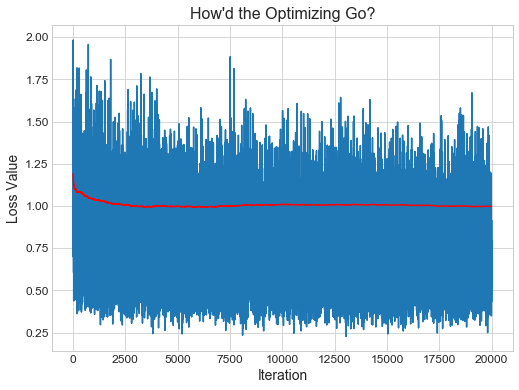

In [607]:
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE'], axis=1)
# add_mean_income(thunderstorm_predictors)
(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

without_income_model = leave_out_Net()

# Train one layer
train_neural_net(without_income_model, outcome_Tensor_train, predictors_Tensor_train,
            outcome_Tensor_test, predictors_Tensor_test)

one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, without_income_model).item()
print("Difference with original mse", one_layer_mse - one_hidden_mse)

Since the MSE is only changing very slightly, we dare not make any hard conclusions about exactly which features are highly impacting the predictions of our model. 

<h2>Finding the best model over 100 iterations</h2>
<p>It seems that whenever we retrain the model, the MSE is slightly different. Therefore, we decided to retrain the one hidden layer and the two hidden layer neural net 100 times and seeing what the best MSE is we can achieve. </p> 

In [ ]:
# *********************
# NOTE: the code below takes a while to run, as it as to go
#       through 100 iterations of retraining, it may take up to 
#       about half an hour for this cell to complete
# *********************

best_model = None
best_mse = 10
for i in range(100):
    data = data.sample(frac=1)
    thunderstorm_outcomes = data.iloc[:, [6]]
    thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE'], axis=1)
    add_mean_income(thunderstorm_predictors)
    (predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)
    
    # define our nets
    one_hidden_model = one_hidden_Net()
    two_hidden_model = two_hidden_Net()
    
    # Train one layer
    train_neural_net(one_hidden_model, outcome_Tensor_train, predictors_Tensor_train,
                outcome_Tensor_test, predictors_Tensor_test)
    # Train two layer
    train_neural_net(two_hidden_model, outcome_Tensor_train, predictors_Tensor_train,
                outcome_Tensor_test, predictors_Tensor_test)
    
    one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, one_hidden_model).item()
    two_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, two_hidden_model).item()
    
    if (one_layer_mse < best_mse):
        best_model = one_hidden_model
        best_mse = one_layer_mse
    if (two_layer_mse < best_mse):
        best_model = two_hidden_model
        best_mse = two_layer_mse
        
print(best_model)
print(best_mse)

(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)
(281, 1)
Shape of outcome array training (281, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (281, 9)
Shape of inputs array test (71, 9)


From training the one hidden layer model and two hidden layer model 100 times on random training and test splits of the data, the best MSE we can achieve is around 0.535 (note that this result may differ when rerunning the cell above because both the data and the optimizing algorithm have random elements in it). We can see from the results above that the two hidden layer model is more prone to overfitting. 

In [610]:
print(best_model)

one_hidden_Net(
  (fc1): Linear(in_features=9, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=1, bias=True)
)
